In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")
from pymatreader import read_mat
import IPython
from pathlib import Path
from utilities import savefig
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [2]:
NB_NAME = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem

In [3]:
DATAPATH = os.path.join(os.path.abspath(""), "data", "pfv_sweep_old_dev")

fnames = []
for i in range(1, 11):
    fpair = []
    for j in range(1, 3):
        fpair.append(os.path.join(DATAPATH, f"freq{i}_p{j}.mat"))
    fnames.append(fpair)


def get_data_pair(pair: list[str]):
    data1, data2 = read_mat(pair[0])["Data"], read_mat(pair[1])["Data"]
    wavelength = 2.99792458e+5 / np.mean([data1["M_freq"], data2["M_freq"]])
    current = np.concatenate((data1["MeasureCurrent"], data2["MeasureCurrent"]), axis=0)
    counts = np.concatenate((data1["MeasureCounts"], data2["MeasureCounts"]), axis=0)
    return wavelength, current, counts

powers = np.arange(2.5, 52.5, 2.5)
voltages = read_mat(fnames[0][0])["Data"]["VoltageList"]
wavelengths = []
counts = []
currents = []

for pair in fnames:
    wl, cu, co = get_data_pair(pair)
    wavelengths.append(wl)
    counts.append(co[:, 5:])
    currents.append(cu[:, 5:]*1e6)

wavelengths = np.array(wavelengths)
counts = np.array(counts)
currents = np.array(currents)

voltages = voltages[5:]

currents_err = np.abs(currents * 0.00025) + 1e-6

/home/ali/miniconda3/envs/university/lib/python3.11/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


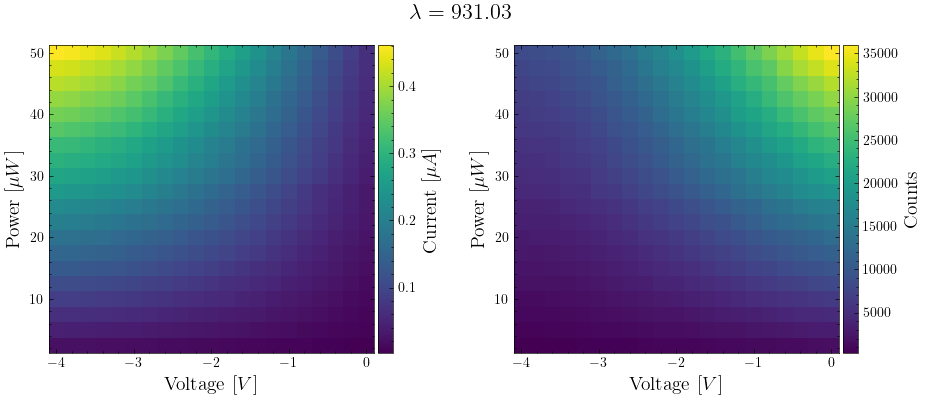

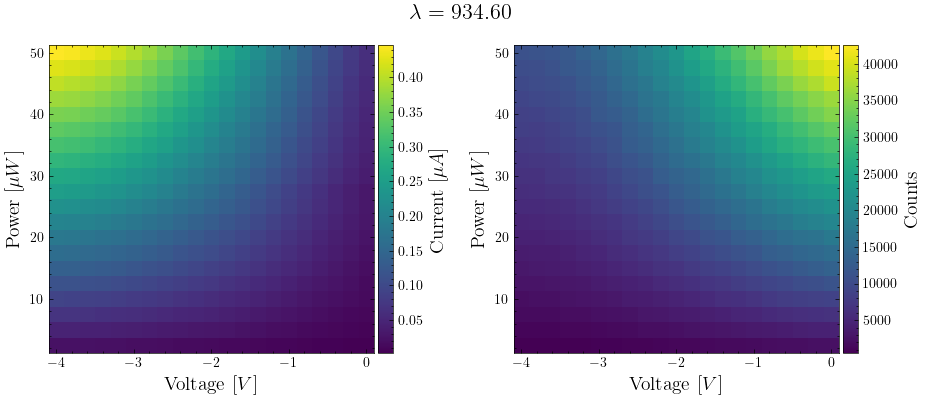

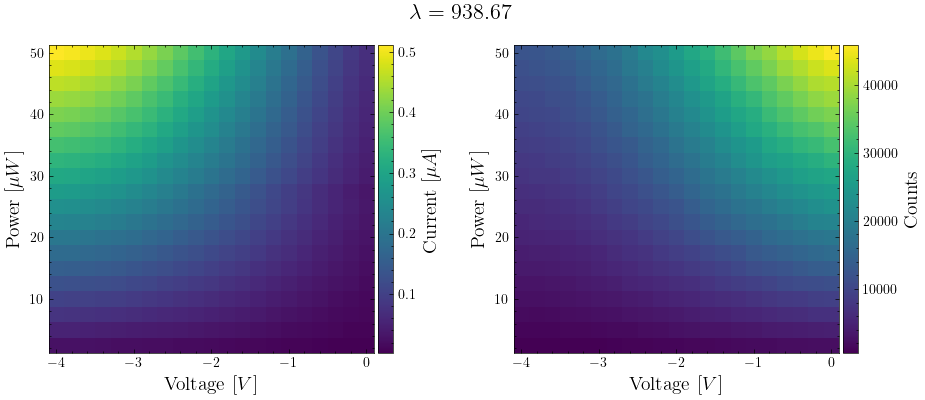

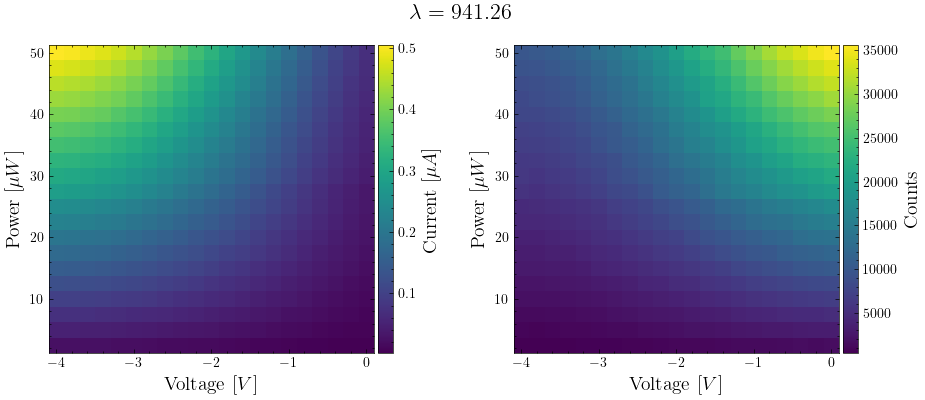

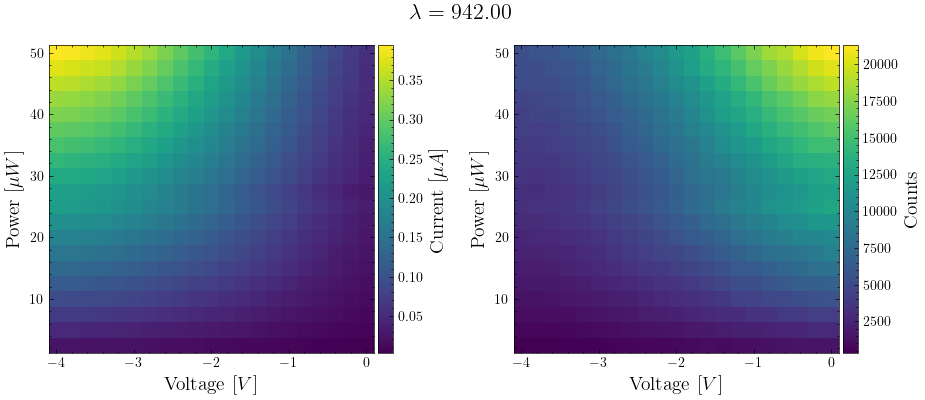

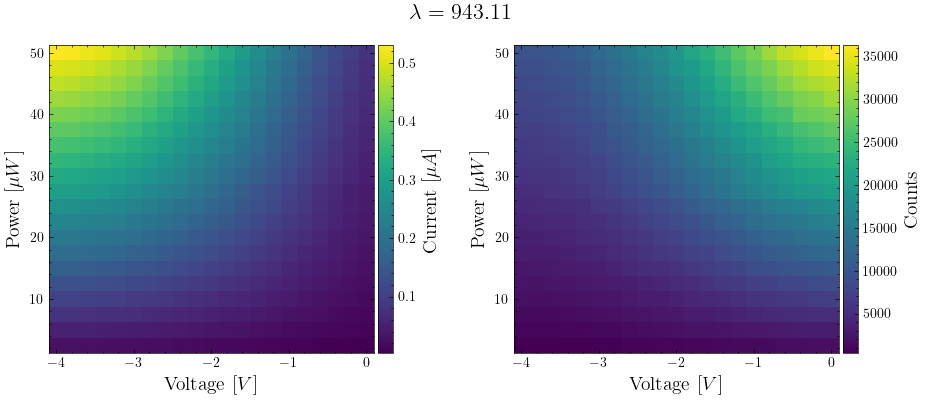

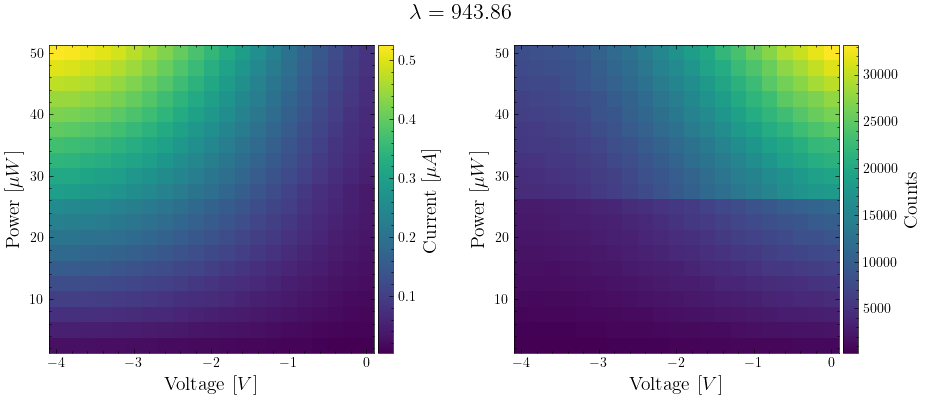

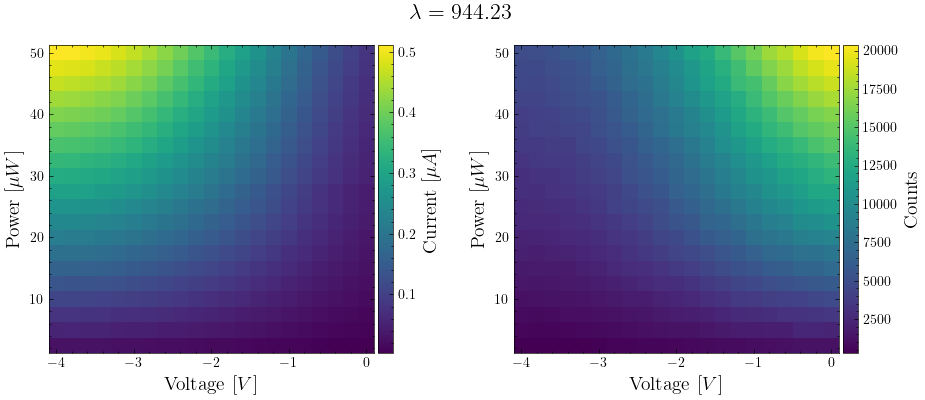

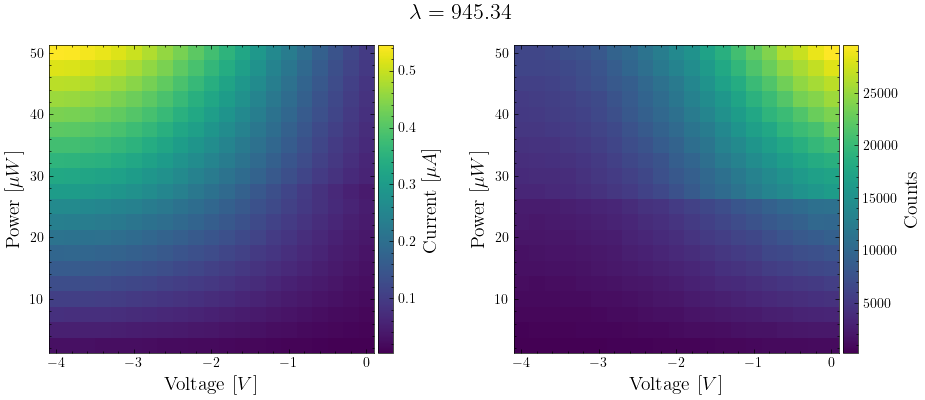

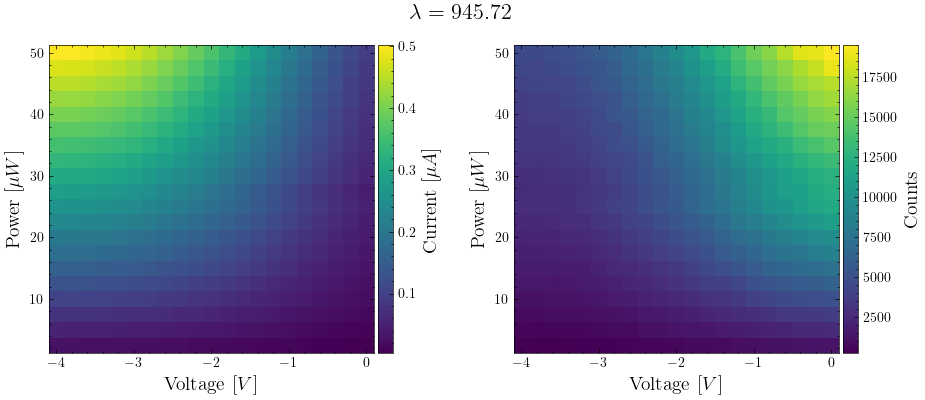

In [4]:
for i in range(len(wavelengths) - 1, -1, -1):
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))

    fig.suptitle(rf'$\lambda = {wavelengths[i]:.2f}$', fontsize=16)
    pcm1 = axs[0].pcolormesh(voltages, powers, np.abs(currents[i]))
    pcm2 = axs[1].pcolormesh(voltages, powers, counts[i])

    axs[0].set_xlabel(r"Voltage [$V$]", fontsize=14)
    axs[0].set_ylabel(r"Power [$\mu W$]", fontsize=14)

    axs[1].set_xlabel(r"Voltage [$V$]", fontsize=14)
    axs[1].set_ylabel(r"Power [$\mu W$]", fontsize=14)

    cb1 = fig.colorbar(pcm1, ax=axs[0], pad = 0.01)
    cb2 = fig.colorbar(pcm2, ax=axs[1], pad = 0.01)

    cb1.set_label(label=r"Current [$\mu A$]", fontsize=14)
    cb2.set_label(label="Counts", fontsize=14)

    plt.show()

In [5]:
I_0_vals = []
res_vals = []
I_0_errs = []
res_errs = []

for i in range(len(currents)):
    I_0_vals_inner = []
    res_vals_inner = []
    I_0_errs_inner = []
    res_errs_inner = []
    for j in range(currents[i].shape[1]):
        P_I_lstsq = LeastSquares(
            powers,
            -currents[i][:, j],
            currents_err[i][:, j],
            model=lambda pow, I_0, res: pow * res + I_0,
        )
        P_I_minuit = Minuit(P_I_lstsq, I_0=-3, res=0.05)
        P_I_minuit.migrad()
        P_I_minuit.hesse()

        I_0_fit, res_fit = P_I_minuit.values[:]
        I_0_fit_err, res_fit_err = P_I_minuit.errors[:]

        I_0_vals_inner.append(I_0_fit)
        res_vals_inner.append(res_fit)

        I_0_errs_inner.append(I_0_fit_err)
        res_errs_inner.append(res_fit_err)

        if not P_I_minuit.accurate or not P_I_minuit.valid:
            print("NOTE: Error occured.")

    I_0_vals.append(I_0_vals_inner)
    res_vals.append(res_vals_inner)

    I_0_errs.append(I_0_errs_inner)
    res_errs.append(res_errs_inner)

In [6]:
I_0_vals = np.array(I_0_vals)
res_vals = np.array(res_vals)
I_0_errs = np.array(I_0_errs)
res_errs = np.array(res_errs)

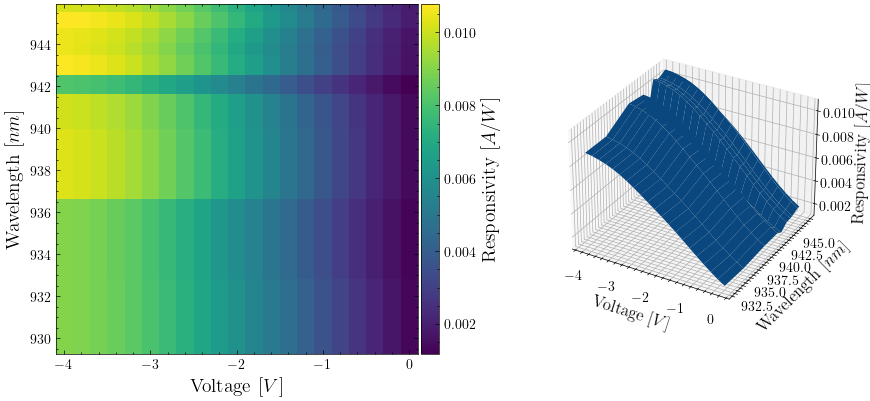

In [7]:
fig = plt.figure(figsize=(9, 4), layout="compressed")
ax = fig.add_subplot(1, 2, 1)
pcm = ax.pcolormesh(voltages, wavelengths, res_vals)
ax.set_xlabel(r"Voltage [$V$]", fontsize=14)
ax.set_ylabel(r"Wavelength [$nm$]", fontsize=14)
cb = fig.colorbar(pcm, ax=ax, pad = 0.01)
cb.set_label(r"Responsivity [$A / W$]", fontsize=14)
ax1 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot_surface(*np.meshgrid(voltages, wavelengths), res_vals)
ax1.set_xlabel(r"Voltage [$V$]", fontsize=12)
ax1.set_ylabel(r"Wavelength [$nm$]", fontsize=12)
ax1.set_zlabel(r"Responsivity [$A / W$]", fontsize=12)
ax1.set_box_aspect(None, zoom=0.8)
# savefig(NB_NAME, "responsivity_fw", fig)
plt.show()